In [52]:
# import libaries
import geopandas as gpd
import pandas as pd
import json
import numpy as np
from sqlalchemy import create_engine
import time
from datetime import date, timedelta
from rl_v2g import CarsharingEnv
import math
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from gym.utils.env_checker import check_env as checker_gym
from stable_baselines3.common.env_checker import check_env as checker_baselines3
import torch
import torch.nn as nn
from stable_baselines3.common.logger import configure
import random
# load the database credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


# Application of Car-sharing Simulation Environment 

Choose the timespan for the simulation. The simulation will be executed chronologically, starting from the first day (2019-1-1) and continuing for subsequent days (2019-1-2, 2019-1-3, etc.). If a start date other than 2019-1-1 is selected, the "Start simulation" cell below may need to be modified.

In [2]:
# set learn period
start_date = date(2019, 1, 8)
end_date = date(2019, 3, 12)
#end_date = date(2019, 1, 10)
start_week = 1
end_week = 9

# set simulation period
start_date_simulation = date(2019, 3, 12)
end_date_simulation = date(2019, 3, 26)
start_week_simulation = 10
end_week_simulation = 11

# calculate number of days to learn
nr_iterations = (end_date - start_date).days

# calculate number of days to simulate
nr_iterations_simulation = (end_date_simulation - start_date_simulation).days

# Load data for simulation

### Car-sharing stations

In [3]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations["x"] = stations.geom.x.values
stations["y"] = stations.geom.y.values
stations.sindex
stations.head()

,station_no,geom,x,y
0,2901,POINT (2555501.836 1145060.068),2.555502e+06,1.145060e+06
1,2905,POINT (2752963.411 1260089.916),2.752963e+06,1.260090e+06
2,2910,POINT (2501877.645 1126218.900),2.501878e+06,1.126219e+06
3,2913,POINT (2682234.096 1243208.370),2.682234e+06,1.243208e+06
4,2918,POINT (2736874.744 1253090.505),2.736875e+06,1.253091e+06


### Vehicle information

In [4]:
# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no limit 15 offset 60"
vehicles = pd.read_sql(sql, engine)
vehicles.head()

,index,vehicle_category,vehicle_no,model_name,brand_name,charge_power,battery_capacity,range
0,3518,Combi,113270,Enyaq iV80,Skoda,11.0,82.0,420.0
1,3519,Combi,113273,Enyaq iV80,Skoda,11.0,82.0,420.0
2,3520,Combi,113276,Enyaq iV80,Skoda,11.0,82.0,420.0
3,3521,Combi,113278,Enyaq iV80,Skoda,11.0,82.0,420.0
4,3522,Combi,113282,Enyaq iV80,Skoda,11.0,82.0,420.0


In [5]:
vehicle_nr_list = vehicles["vehicle_no"].tolist()

### Reservations

In [6]:
# get daily reservations, save in dict for fast data access
delta = timedelta(days=1)
reservations_dict = {}
start_date_reservations = start_date
while start_date_reservations <= end_date:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}' 
            ORDER BY reservationfrom_discrete""".format(start_date_reservations, start_date_reservations, vehicle_nr_list) 
    reservations = pd.read_sql(sql, engine)
    reservations = reservations[reservations['vehicle_no'].isin(vehicle_nr_list)]
    reservations_dict[start_date_reservations.strftime('%Y-%m-%d')] = reservations
    start_date_reservations += delta     
reservations_dict[(start_date).strftime('%Y-%m-%d')].head()

,reservation_no,start_station_no,vehicle_no,reservationfrom_time_discrete,drive_firststart_time_discrete,drive_lastend_time_discrete,reservation_duration,revenue_distance,required_soc,revenue_duration,drive_km,drive_duration
36,24546730,1116,113337,690.0,690.0,697.0,8.0,6.05,4.230769,5.0,11.0,7.0
274,24543641,2796,113334,700.0,704.0,740.0,42.0,29.25,17.307692,31.5,45.0,37.0
435,24538753,3235,113289,702.0,702.0,705.0,4.0,0.00,0.000000,0.0,6.0,3.0
495,24546493,3207,113332,704.0,704.0,711.0,8.0,13.75,9.615385,4.0,25.0,7.0
869,24545449,2276,113276,708.0,718.0,718.0,12.0,0.00,0.000000,0.0,0.0,1.0


In [7]:
# get daily reservations, save in dict for fast data access
delta = timedelta(days=1)
reservations_dict_simulation = {}
start_date_reservations = start_date_simulation
while start_date_reservations <= end_date_simulation:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}'
            ORDER BY reservationfrom_discrete""".format(start_date_reservations, start_date_reservations, vehicle_nr_list)
    reservations = pd.read_sql(sql, engine)
    reservations = reservations[reservations['vehicle_no'].isin(vehicle_nr_list)]
    reservations_dict_simulation[start_date_reservations.strftime('%Y-%m-%d')] = reservations
    start_date_reservations += delta
reservations_dict_simulation[(start_date_simulation).strftime('%Y-%m-%d')].head()

,reservation_no,start_station_no,vehicle_no,reservationfrom_time_discrete,drive_firststart_time_discrete,drive_lastend_time_discrete,reservation_duration,revenue_distance,required_soc,revenue_duration,drive_km,drive_duration
20,24813323,3207,113332,6722.0,6724.0,6757.0,36.0,7.15,5.000000,18.0,13.0,33.0
39,24796897,1116,113337,6738.0,6738.0,6744.0,8.0,6.05,4.230769,5.0,11.0,8.0
946,24811124,4501,113278,6754.0,6754.0,6768.0,14.0,28.80,8.571429,12.0,36.0,14.0
1064,24718059,1505,113273,6756.0,6757.0,6790.0,34.0,125.60,85.000000,164.5,357.0,33.0
1192,24769391,3131,113282,6756.0,6757.0,6759.0,4.0,8.80,2.619048,9.0,11.0,4.0


In [8]:
reservations_dict.keys()

dict_keys(['2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11', '2019-03-12'])

In [9]:
reservations_dict_simulation.keys()

dict_keys(['2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25', '2019-03-26'])

### Electicity prices for charging

In [10]:
# get charging costs data
prices = ""
for i in range(0, 480, 5):
    price = i / 20
    prices += '"Price_chf_kwh_{}", '.format(price)

sql = """SELECT {} "Delivery day" FROM msc_2023_dominik.charging_costs WHERE "Delivery day" >=  '{}' and "Delivery day" <=  '{}' ORDER BY "Delivery day" """.format(prices, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

charging_costs = pd.read_sql(sql, engine)
charging_costs.head()

,Price_chf_kwh_0.0,Price_chf_kwh_0.25,Price_chf_kwh_0.5,Price_chf_kwh_0.75,Price_chf_kwh_1.0,Price_chf_kwh_1.25,Price_chf_kwh_1.5,Price_chf_kwh_1.75,Price_chf_kwh_2.0,Price_chf_kwh_2.25,...,Price_chf_kwh_21.75,Price_chf_kwh_22.0,Price_chf_kwh_22.25,Price_chf_kwh_22.5,Price_chf_kwh_22.75,Price_chf_kwh_23.0,Price_chf_kwh_23.25,Price_chf_kwh_23.5,Price_chf_kwh_23.75,Delivery day
0,0.055468,0.055468,0.055468,0.055468,0.050245,0.050245,0.050245,0.050245,0.049484,0.049484,...,0.065208,0.065165,0.065165,0.065165,0.065165,0.061071,0.061071,0.061071,0.061071,2019-01-08
1,0.061907,0.061907,0.061907,0.061907,0.057564,0.057564,0.057564,0.057564,0.057086,0.057086,...,0.067586,0.067641,0.067641,0.067641,0.067641,0.064112,0.064112,0.064112,0.064112,2019-01-09
2,0.062939,0.062939,0.062939,0.062939,0.058443,0.058443,0.058443,0.058443,0.058150,0.058150,...,0.072842,0.070312,0.070312,0.070312,0.070312,0.061842,0.061842,0.061842,0.061842,2019-01-10
3,0.068889,0.068889,0.068889,0.068889,0.061907,0.061907,0.061907,0.061907,0.060854,0.060854,...,0.072212,0.071756,0.071756,0.071756,0.071756,0.069389,0.069389,0.069389,0.069389,2019-01-11
4,0.067521,0.067521,0.067521,0.067521,0.061951,0.061951,0.061951,0.061951,0.059366,0.059366,...,0.058595,0.061353,0.061353,0.061353,0.061353,0.058606,0.058606,0.058606,0.058606,2019-01-12


In [11]:
# save in dict for fast data access
delta = timedelta(days=1)
charging_costs_dict = {}
start_date_electricity = start_date
while start_date_electricity <= end_date:
    electricity_price_day = charging_costs[charging_costs["Delivery day"].dt.date == start_date_electricity].drop(["Delivery day"],axis = 1).iloc[0].values
    charging_costs_dict[start_date_electricity.strftime('%Y-%m-%d')] = electricity_price_day
    start_date_electricity += delta

In [12]:
charging_costs_dict.keys()

dict_keys(['2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11', '2019-03-12'])

In [13]:
# get charging costs data
prices = ""
for i in range(0, 480, 5):
    price = i / 20
    prices += '"Price_chf_kwh_{}", '.format(price)

sql = """SELECT {} "Delivery day" FROM msc_2023_dominik.charging_costs WHERE "Delivery day" >=  '{}' and "Delivery day" <=  '{}' ORDER BY "Delivery day" """.format(prices, start_date_simulation.strftime('%Y-%m-%d'), end_date_simulation.strftime('%Y-%m-%d'))

charging_costs = pd.read_sql(sql, engine)
charging_costs.head()

,Price_chf_kwh_0.0,Price_chf_kwh_0.25,Price_chf_kwh_0.5,Price_chf_kwh_0.75,Price_chf_kwh_1.0,Price_chf_kwh_1.25,Price_chf_kwh_1.5,Price_chf_kwh_1.75,Price_chf_kwh_2.0,Price_chf_kwh_2.25,...,Price_chf_kwh_21.75,Price_chf_kwh_22.0,Price_chf_kwh_22.25,Price_chf_kwh_22.5,Price_chf_kwh_22.75,Price_chf_kwh_23.0,Price_chf_kwh_23.25,Price_chf_kwh_23.5,Price_chf_kwh_23.75,Delivery day
0,0.048333,0.048333,0.048333,0.048333,0.044088,0.044088,0.044088,0.044088,0.041058,0.041058,...,0.037268,0.038115,0.038115,0.038115,0.038115,0.036508,0.036508,0.036508,0.036508,2019-03-12
1,0.032001,0.032001,0.032001,0.032001,0.030449,0.030449,0.030449,0.030449,0.033044,0.033044,...,0.037996,0.039331,0.039331,0.039331,0.039331,0.037181,0.037181,0.037181,0.037181,2019-03-13
2,0.031404,0.031404,0.031404,0.031404,0.027126,0.027126,0.027126,0.027126,0.027202,0.027202,...,0.034238,0.034629,0.034629,0.034629,0.034629,0.031676,0.031676,0.031676,0.031676,2019-03-14
3,0.028798,0.028798,0.028798,0.028798,0.025931,0.025931,0.025931,0.025931,0.022304,0.022304,...,0.031144,0.031448,0.031448,0.031448,0.031448,0.025758,0.025758,0.025758,0.025758,2019-03-15
4,0.023955,0.023955,0.023955,0.023955,0.023325,0.023325,0.023325,0.023325,0.013215,0.013215,...,0.021457,0.024281,0.024281,0.024281,0.024281,0.022337,0.022337,0.022337,0.022337,2019-03-16


In [14]:
# save in dict for fast data access
delta = timedelta(days=1)
charging_costs_dict_simulation = {}
start_date_electricity = start_date_simulation
while start_date_electricity <= end_date_simulation:
    electricity_price_day = charging_costs[charging_costs["Delivery day"].dt.date == start_date_electricity].drop(["Delivery day"],axis = 1).iloc[0].values
    charging_costs_dict_simulation[start_date_electricity.strftime('%Y-%m-%d')] = electricity_price_day
    start_date_electricity += delta

In [15]:
charging_costs_dict_simulation.keys()

dict_keys(['2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25', '2019-03-26'])

### Secondary energy prices (for V2G)

In [16]:
# get v2g price data
sql = """SELECT "Timestamp", "Secondary_positive_v2g_prices_chf_kwh", "Secondary_negative_v2g_prices_chf_kwh" FROM msc_2023_dominik.v2g_prices WHERE "Timestamp" >=  '{}' and "Timestamp" <=  '{}' ORDER BY "Timestamp" """.format(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
v2g_prices = pd.read_sql(sql, engine)
v2g_prices.head()

,Timestamp,Secondary_positive_v2g_prices_chf_kwh,Secondary_negative_v2g_prices_chf_kwh
0,2019-01-08 00:00:00,0.052801,0.035201
1,2019-01-08 00:15:00,0.052687,0.035132
2,2019-01-08 00:30:00,0.052687,0.035132
3,2019-01-08 00:45:00,0.052687,0.035132
4,2019-01-08 01:00:00,0.052687,0.035132


In [17]:
# save in dict for fast data access
delta = timedelta(days=1)
v2g_price_dict = {}
start_date_v2g = start_date
while start_date_v2g <= end_date:
    v2g_price_day_positive = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_positive_v2g_prices_chf_kwh"].values
    v2g_price_day_negative = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_negative_v2g_prices_chf_kwh"].values
    v2g_price_dict[start_date_v2g.strftime('%Y-%m-%d')] = [v2g_price_day_positive, v2g_price_day_negative]
    start_date_v2g += delta

In [18]:
v2g_price_dict.keys()

dict_keys(['2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11', '2019-03-12'])

In [19]:
# get v2g price data
sql = """SELECT "Timestamp", "Secondary_positive_v2g_prices_chf_kwh", "Secondary_negative_v2g_prices_chf_kwh" FROM msc_2023_dominik.v2g_prices WHERE "Timestamp" >=  '{}' and "Timestamp" <=  '{}' ORDER BY "Timestamp" """.format(start_date_simulation.strftime('%Y-%m-%d'), end_date_simulation.strftime('%Y-%m-%d'))
v2g_prices = pd.read_sql(sql, engine)
v2g_prices.head()

,Timestamp,Secondary_positive_v2g_prices_chf_kwh,Secondary_negative_v2g_prices_chf_kwh
0,2019-03-12 00:00:00,0.068776,0.045843
1,2019-03-12 00:15:00,0.066090,0.044053
2,2019-03-12 00:30:00,0.066090,0.044053
3,2019-03-12 00:45:00,0.066090,0.044053
4,2019-03-12 01:00:00,0.066090,0.044053


In [20]:
# save in dict for fast data access
delta = timedelta(days=1)
v2g_price_dict_simulation = {}
start_date_v2g = start_date_simulation
while start_date_v2g <= end_date_simulation:
    v2g_price_day_positive = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_positive_v2g_prices_chf_kwh"].values
    v2g_price_day_negative = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_negative_v2g_prices_chf_kwh"].values
    v2g_price_dict_simulation[start_date_v2g.strftime('%Y-%m-%d')] = [v2g_price_day_positive, v2g_price_day_negative]
    start_date_v2g += delta

In [21]:
v2g_price_dict_simulation.keys()

dict_keys(['2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25', '2019-03-26'])

# Check environment

In [22]:
# check if enviornment fullfils requirements of gym and stable-baselines3

# load discrete table
sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(0)
data = pd.read_sql(sql, engine)
    
# load discrete planned reservation table
sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(0)
planned_reservations = pd.read_sql(sql, engine)
    
# load discrete planned reservation duration table
sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(0)
planned_durations = pd.read_sql(sql, engine)
end = time.time()

# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(start_week, 1):
    # iteration for each day
    counter = 0
    for day in range(98,99,96):
        
        # calculate number of timesteps since first day of simulation
        timesteps_since_start = count * 96
        
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        # create environment
        env = CarsharingEnv(stations, vehicles, planned_bookings = True, v2g_penalty = 10000, penalty_per_kwh = 0, daily_data = daily_data, reservations = reservations,
                           electricity_price = electricity_price, timesteps_since_start = timesteps_since_start, v2g_price = v2g_price, planned_reservations = planned_reservations_day,
                           planned_durations = planned_durations_day, RL = True)
        
        # check implementation 
        checker_gym(env)
        checker_baselines3(env)
        # count number of simulated days
  
        



# Environment Setup

In [23]:
param_dict_daily = {
    "planned_bookings": False,
    "precomputed_bookings": True,
    "location_state": "binary",
    "normalize_state": True,
    "random_seed_number": 42,
    "max_charging_power": 11,
    "soc_initial_low": 0.5,
    "soc_initial_high": 1.0,
    "max_distance_car_assignment": 1000,
    "penalty_per_kwh": 1.0,
    "cancellation_penalty": 0,
    "v2g": True,
    "v2g_demand_event_min": 10,
    "v2g_demand_event_max": 10,
    "v2g_max_duration": 2.0,
    "v2g_penalty": 100,
    "v2g_penalty_quantity_dependent": True,
    "v2g_probability_charging_event": 0.5,
    "v2g_probability_discharging_event": 0.5,
    "v2g_morning_time_period": [6.0, 9.0, 11.00],
    "v2g_noon_time_period": [11.25, 14.0, 15.75],
    "v2g_evening_time_period": [16.0, 20.0, 22.0],
    "plot_state_histogram": False,
    "plot_state_animation": False
}

param_dict_long_term = {
    "planned_bookings": False,
    "precomputed_bookings": True,
    "location_state": "binary",
    "normalize_state": True,
    "random_seed_number": 42,
    "max_charging_power": 11,
    "soc_initial_low": 0.5,
    "soc_initial_high": 1.0,
    "max_distance_car_assignment": 1000,
    "penalty_per_kwh": 0.0,
    "cancellation_penalty": 0,
    "v2g": True,
    "v2g_demand_event_min": 10,
    "v2g_demand_event_max": 10,
    "v2g_max_duration": 2.0,
    "v2g_penalty": 100,
    "v2g_penalty_quantity_dependent": True,
    "v2g_probability_charging_event": 0.5,
    "v2g_probability_discharging_event": 0.5,
    "v2g_morning_time_period": [6.0, 9.0, 11.00],
    "v2g_noon_time_period": [11.25, 14.0, 15.75],
    "v2g_evening_time_period": [16.0, 20.0, 22.0],
    "plot_state_histogram": False,
    "plot_state_animation": False
}

# Train Agent

### Implementation of heuristic smart charging algorithm

In [24]:
def smart_charging(state, v2g_demand = 10, threshold = 0.8):
    # get state
    nr_vehicles = len(vehicles)
    actions = np.ones(nr_vehicles)
    locations = state[:nr_vehicles]
    soc = state[nr_vehicles:nr_vehicles*2]

    v2g = state[nr_vehicles *2:nr_vehicles*2+1]
    time = state[nr_vehicles *2 + 1:]

    # do nothing for cars that are on trip
    actions[locations == 0] = 0

    # do not charge vehicles over 70% (there are charging events)
    actions[soc > threshold] = 0

    if v2g[0] > 0.5:
        #discharging event
         # set soc to 0 for vehicles not at stations
        soc_dis = soc.copy()  
        soc_dis[locations == 0] = 0
        sorted_soc = np.argsort(soc)
        indices = None
        for i in range(5, 16):
            indices = sorted_soc[-i:]
            if vehicles["charge_power"].values[indices].sum() * 0.25 > v2g_demand:
                break
        actions[indices] = 2
        
    if v2g[0] < 0.5:
        #charging event
        soc_ch = soc.copy()  
        soc_ch[locations == 0] = 1
        sorted_soc = np.argsort(soc_ch)
        indices = None
        for i in range(5, 16):
            indices = sorted_soc[:i]
            if vehicles["charge_power"].values[indices].sum() * 0.25 > v2g_demand:
                break
        actions[indices] = 1

    return actions
        


### Tune heuristic smart charging algorithm

In [25]:
def validation_smart_charging_tuning(v2g_demand, environment_parameter, threshold = 10, reset = True):
    nr_vehicles = len(vehicles)
    
    global nr_iterations_simulation

    # maximal simulation length
    if nr_iterations_simulation > 577:
        nr_iterations_simulation = 577
        
    total_reward = 0

    count = 0
    # iterate over weeks (for loading weekly discrete data) start_week_simulation
    for week_nr in range(start_week, end_week + 1):
        # load discrete car-sharing table
        sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        data = pd.read_sql(sql, engine)

        # load discrete planned reservation table
        sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        planned_reservations = pd.read_sql(sql, engine)

        # load discrete planned reservation duration table
        sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        planned_durations = pd.read_sql(sql, engine)
        
        counter_day_in_week = 0
        # iteration for each day
        for day in range(98,676,96):
            # calculate number of timesteps since first day of simulation
            timesteps_since_start = counter_day_in_week * 96 + week_nr * 96 * 7

            # all requested days are simulated
            if count == nr_iterations:
                break

            # get date
            date_day = pd.to_datetime(data.columns[day-97]).date()
            date_day_string = date_day.strftime('%Y-%m-%d')

            # load reservations
            reservations = reservations_dict[date_day_string]

            # load electricity prices for charging
            electricity_price = charging_costs_dict[date_day_string]

            # load secondary energy prices for v2g
            v2g_price = v2g_price_dict[date_day_string]

            # select discrete data of day
            daily_data = data.iloc[:,day-97:day-1]
            planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
            planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 

            # reset environment at beginnning of simulation
            if count == 0:
                environment_parameter["stations"] = stations
                environment_parameter["vehicle_information"] = vehicles
                environment_parameter["daily_data"] = daily_data
                environment_parameter["reservations"] = reservations
                environment_parameter["electricity_price"] = electricity_price
                environment_parameter["timesteps_since_start"] = timesteps_since_start
                environment_parameter["planned_reservations"] = planned_reservations_day
                environment_parameter["planned_durations"] = planned_durations_day
                environment_parameter["v2g_price"] = v2g_price
                env = CarsharingEnv(**environment_parameter)
                s = env.reset()


            # beginn new day without reseting environemnt 
            if count > 0:
                if reset:
                    env.load_new_data(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
                    s = env.reset()
                else: 
                    env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)

            # simulate day in 15 min steps
            done = False
            counter = 0
            while not done:

                # proceed one time step
                s, rew, done, _ = env.step(smart_charging(s, v2g_demand, threshold))
                
                total_reward += rew

                counter +=1

            # plot summary statistics of episode (day)
            #environment.daily_summary_statistics()

            # plot summary statistic over full simulation period
            #if count == nr_iterations - 1:
              #  environment.episode_summary_statistics(nr_iterations)

            # count number of simulated days
            count += 1
            counter_day_in_week +=1
            
    return total_reward 

In [26]:
for i in range(10, 110, 10):
    r = validation_smart_charging_tuning(10, param_dict_daily, i/100, reset = True)
    print("Threshold SOC: ",i/100)
    print("Reward training: ",r," CHF")

Threshold SOC:  0.1
Reward training:  16427.903446989316  CHF
Threshold SOC:  0.2
Reward training:  16543.53821794145  CHF
Threshold SOC:  0.3
Reward training:  16813.33064925702  CHF
Threshold SOC:  0.4
Reward training:  18848.302706017523  CHF
Threshold SOC:  0.5
Reward training:  20723.754772786036  CHF
Threshold SOC:  0.6
Reward training:  24498.97645827653  CHF
Threshold SOC:  0.7
Reward training:  29080.26792471381  CHF
Threshold SOC:  0.8
Reward training:  29612.46702976512  CHF
Threshold SOC:  0.9
Reward training:  23391.97799102911  CHF
Threshold SOC:  1.0
Reward training:  12929.356460962648  CHF


In [27]:
for i in range(10, 110, 10):
    r = validation_smart_charging_tuning(10, param_dict_long_term, i/100, reset = True)
    print("Threshold SOC: ",i/100)
    print("Reward training: ",r," CHF")

Threshold SOC:  0.1
Reward training:  27361.58749665219  CHF
Threshold SOC:  0.2
Reward training:  27392.660799926944  CHF
Threshold SOC:  0.3
Reward training:  27399.825154319442  CHF
Threshold SOC:  0.4
Reward training:  28459.437950359374  CHF
Threshold SOC:  0.5
Reward training:  28618.65904842358  CHF
Threshold SOC:  0.6
Reward training:  29595.175322162144  CHF
Threshold SOC:  0.7
Reward training:  30959.848558207756  CHF
Threshold SOC:  0.8
Reward training:  29729.914822696184  CHF
Threshold SOC:  0.9
Reward training:  23391.97799102911  CHF
Threshold SOC:  1.0
Reward training:  12929.356460962648  CHF


### Train and validate models

In [28]:
# check support of GPU
stable_baselines3.common.utils.get_device(device='cpu')

device(type='cpu')

In [65]:
def validation(environment_parameter, model = None, mode = "RL", reset = False):
    nr_vehicles = len(vehicles)
    
    global nr_iterations_simulation

    # maximal simulation length
    if nr_iterations_simulation > 577:
        nr_iterations_simulation = 577
        
    total_reward = 0

    count = 0
    # iterate over weeks (for loading weekly discrete data)
    for week_nr in range(start_week_simulation, end_week_simulation + 1):
        # load discrete car-sharing table
        sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        data = pd.read_sql(sql, engine)

        # load discrete planned reservation table
        sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        planned_reservations = pd.read_sql(sql, engine)

        # load discrete planned reservation duration table
        sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        planned_durations = pd.read_sql(sql, engine)
        
        counter_day_in_week = 0
        # iteration for each day
        for day in range(98,676,96):
            # calculate number of timesteps since first day of simulation
            timesteps_since_start = counter_day_in_week * 96 + week_nr * 96 * 7


            # all requested days are simulated
            if count == nr_iterations:
                break

            # get date
            date_day = pd.to_datetime(data.columns[day-97]).date()
            date_day_string = date_day.strftime('%Y-%m-%d')

            # load reservations
            reservations = reservations_dict_simulation[date_day_string]

            # load electricity prices for charging
            electricity_price = charging_costs_dict_simulation[date_day_string]

            # load secondary energy prices for v2g
            v2g_price = v2g_price_dict_simulation[date_day_string]

            # select discrete data of day
            daily_data = data.iloc[:,day-97:day-1]
            planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
            planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 

            # reset environment at beginnning of simulation
            if count == 0:
                environment_parameter["stations"] = stations
                environment_parameter["vehicle_information"] = vehicles
                environment_parameter["daily_data"] = daily_data
                environment_parameter["reservations"] = reservations
                environment_parameter["electricity_price"] = electricity_price
                environment_parameter["timesteps_since_start"] = timesteps_since_start
                environment_parameter["planned_reservations"] = planned_reservations_day
                environment_parameter["planned_durations"] = planned_durations_day
                environment_parameter["v2g_price"] = v2g_price
                env = CarsharingEnv(**environment_parameter)
                s = env.reset()

            # beginn new day without reseting environemnt 
            if count > 0:
                if reset:
                    env.load_new_data(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
                    s = env.reset()
                else: 
                    env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)                

            # simulate day in 15 min steps
            done = False
            counter = 0
            while not done:

                # get your action 
                if mode == "RL":
                    act, _states = model.predict(s)
                if mode == "random":
                    act = np.random.randint(0, 3, size=len(vehicles))
                if mode == "heuristic":
                    act = smart_charging(s)
                    
                # proceed one time step
                s, rew, done, _ = env.step(act)
                
                total_reward += rew

                counter +=1

            # plot summary statistics of episode (day)
            #environment.daily_summary_statistics()

            # plot summary statistic over full simulation period
            #if count == nr_iterations - 1:
              #  environment.episode_summary_statistics(nr_iterations)

            # count number of simulated days
            count += 1
            counter_day_in_week +=1
            
    return total_reward 

In [66]:
from stable_baselines3.common.vec_env import DummyVecEnv

In [68]:
#%%snakeviz


# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577

reward_list_daily = []
reward_list_long_term = []
reward_list_random_daily = []
reward_list_random_long_term = []
reward_list_smart_charging_daily = []
reward_list_smart_charging_long_term = []
count_list = []
count = 0
learning_rate_change = 0
model = None
# iterate over weeks (for loading weekly discrete data)
for j in range(0,1430):
    week_nr =  random.randint(start_week, end_week)
    
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
    data = pd.read_sql(sql, engine)

        # load discrete planned reservation table
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)

        # load discrete planned reservation duration table
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
    counter = 0
    # iteration for each day
    for day in range(98,676,96):

        # calculate number of timesteps since first day of simulation
        timesteps_since_start = counter * 96 + week_nr * 96 * 7
        
         #print("timesteps_since_start")
         #print(timesteps_since_start)

        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')

        # load reservations
        reservations = reservations_dict[date_day_string]

        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]

        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]

        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 

        # reset environment at beginnning of simulation
        if count == 0:
            param_dict_daily["stations"] = stations
            param_dict_daily["vehicle_information"] = vehicles
            param_dict_daily["daily_data"] = daily_data
            param_dict_daily["reservations"] = reservations
            param_dict_daily["electricity_price"] = electricity_price
            param_dict_daily["timesteps_since_start"] = timesteps_since_start
            param_dict_daily["planned_reservations"] = planned_reservations_day
            param_dict_daily["planned_durations"] = planned_durations_day
            param_dict_daily["v2g_price"] = v2g_price
            env = DummyVecEnv([lambda: CarsharingEnv(**param_dict_daily)] * 6)
            s = env.reset()

            # create RL model
             #model = PPO("MlpPolicy",environment, verbose=2, ent_coef=0.0, stats_window_size = 10, n_epochs = 1, n_steps=95, batch_size = 95, device ="cpu", max_grad_norm = 10)
            model = A2C("MlpPolicy",environment, verbose=2, device ="cpu", n_steps=3,stats_window_size = 100, gamma = 0.99, learning_rate=0.000003,  vf_coef=0.25, ent_coef=0.03, max_grad_norm=0.5, seed=15151515)
            #model.policy.mlp_extractor.policy_net = nn.Sequential(
            #    nn.Linear(model.policy.mlp_extractor.policy_net[0].in_features, 100),  # Modify the first layer
            #    nn.Tanh(),
             #   nn.Linear(100, 42),
             #   model.policy.mlp_extractor.policy_net[3]
            #)
            #model.policy.action_net =  nn.Linear(42, 300)
            #model.policy.mlp_extractor.value_net = nn.Sequential(
            #    nn.Linear(model.policy.mlp_extractor.value_net[0].in_features, 42),  # Modify the first layer
            #    nn.Tanh(),
            #    nn.Linear(42, 42),
            #    model.policy.mlp_extractor.value_net[3]
            #)
            #model.policy.value_net =  nn.Linear(42, 1)
            new_logger = configure( "/tmp/sb3_log/", ["csv", "stdout"])
            model.set_logger(new_logger)

            #model.policy.to(device)
            
            count_list.append(count)
            r = validation(param_dict_daily, model = model, mode = "RL", reset = True) 
            print("Validation reward single-day: ", r, " CHF   Episodes learned: ",count)
            reward_list_daily.append(r)
            r = validation(param_dict_long_term, model = model, mode = "RL", reset = False) 
            print("Validation reward long-term: ", r, " CHF   Episodes learned: ",count)
            reward_list_long_term.append(r)
            
            r = validation(param_dict_daily, mode = "random", reset = True)
            print("Random validation reward single-day: ", r, " CHF   Episodes learned: ",count)
            reward_list_random_daily.append(r)
            r = validation(param_dict_long_term, mode = "random", reset = False)
            print("Random validation reward long-term: ", r, " CHF   Episodes learned: ",count)
            reward_list_random_long_term.append(r)
            
            reward_smart_charging = validation(param_dict_daily, mode = "heuristic", reset = True)
            print("Heuristic validation reward single-day: ", reward_smart_charging, " CHF   Episodes learned: ",count)
            reward_list_smart_charging_daily.append(reward_smart_charging)
            reward_smart_charging_long_term = validation(param_dict_long_term, mode = "heuristic", reset = False)
            print("Heuristic validation reward long-term: ", reward_smart_charging_long_term, " CHF   Episodes learned: ",count)
            reward_list_smart_charging_long_term.append(reward_smart_charging_long_term)

        else: 
            environment.load_new_data(daily_data = daily_data, reservations = reservations,
                          electricity_price = electricity_price, timesteps_since_start = timesteps_since_start, v2g_price = v2g_price, planned_reservations = planned_reservations_day,
                          planned_durations = planned_durations_day)
            s = environment.reset()
        

        # learn one episode
        model.learn(total_timesteps=95, reset_num_timesteps=True, log_interval  = 945)

        if day == 674:
            count_list.append(count + 1)
            r = validation(param_dict_daily, model = model, mode = "RL", reset = True) 
            print("Validation reward single-day: ", r, " CHF   Episodes learned: ",count+ 1)
            reward_list_daily.append(r)
            r = validation(param_dict_long_term, model = model, mode = "RL", reset = False) 
            print("Validation reward long-term: ", r, " CHF   Episodes learned: ",count+ 1)
            reward_list_long_term.append(r)
            
            r = validation(param_dict_daily, mode = "random", reset = True)
            print("Random validation reward single-day: ", r, " CHF   Episodes learned: ",count+ 1)
            reward_list_random_daily.append(r)
            r = validation(param_dict_long_term, mode = "random", reset = False)
            print("Random validation reward long-term: ", r, " CHF   Episodes learned: ",count+ 1)
            reward_list_random_long_term.append(r)
            
            print("Heuristic validation reward single-day: ", reward_smart_charging, " CHF   Episodes learned: ",count+ 1)
            reward_list_smart_charging_daily.append(reward_smart_charging)
            print("Heuristic validation reward long-term: ", reward_smart_charging_long_term, " CHF   Episodes learned: ",count+ 1)
            reward_list_smart_charging_long_term.append(reward_smart_charging_long_term)

            environment.random_seed_number = random.randint(1, 99999)
            
        if count* 10 > 1800 and learning_rate_change == 0:
            learning_rate_change += 1
            model.nsteps = 4
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 2300 and learning_rate_change == 1:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 2800 and learning_rate_change == 2:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 3300 and learning_rate_change == 3:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 3800 and learning_rate_change == 4:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 4300 and learning_rate_change == 5:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 4800 and learning_rate_change == 6:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8

        counter += 1

        count += 1

    

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /tmp/sb3_log/
Validation reward single-day:  1139.0922232900382  CHF   Episodes learned:  0
Validation reward long-term:  -2354.350874760611  CHF   Episodes learned:  0
Random validation reward single-day:  1952.2536715548172  CHF   Episodes learned:  0
Random validation reward long-term:  -2267.7769022321745  CHF   Episodes learned:  0
Heuristic validation reward single-day:  8157.987104518611  CHF   Episodes learned:  0
Heuristic validation reward long-term:  7653.451238225289  CHF   Episodes learned:  0
Validation reward single-day:  1999.6527531432378  CHF   Episodes learned:  7
Validation reward long-term:  -2111.6663049390313  CHF   Episodes learned:  7
Random validation reward single-day:  1041.8797605282898  CHF   Episodes learned:  7
Random validation reward long-term:  -2222.547560112937  CHF   Episodes learned:  7
Heuristic validation reward single-day:  8157.987104518611

Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\domin\anaconda3\envs\simulation_car_sharing\lib\site-packages\sqlalchemy\pool\base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\domin\anaconda3\envs\simulation_car_sharing\lib\site-packages\sqlalchemy\pool\base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\domin\anaconda3\envs\simulation_car_sharing\lib\site-packages\sqlalchemy\engine\default.py", line 682, in do_rollback
    dbapi_connection.rollback()
psycopg2.errors.AdminShutdown: terminating connection due to administrator command
SSL connection has been closed unexpectedly



OperationalError: (psycopg2.OperationalError) could not connect to server: Connection refused (0x0000274D/10061)
	Is the server running on host "ikgstudigis.ethz.ch" (195.176.107.181) and accepting
	TCP/IP connections on port 5432?

(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [69]:
np.save("reward_list_a2c_daily_2", reward_list_daily)
np.save("reward_list_a2c_long_term_2", reward_list_long_term)

np.save("reward_list_random_daily_2", reward_list_random_daily)
np.save("reward_list_random_long_term_2", reward_list_random_long_term)

np.save("reward_list_heuristic_daily_2", reward_list_smart_charging_daily)
np.save("reward_list_heuristic_long_term_2", reward_list_smart_charging_long_term)

np.save("reward_list_learned_days_2", count_list)


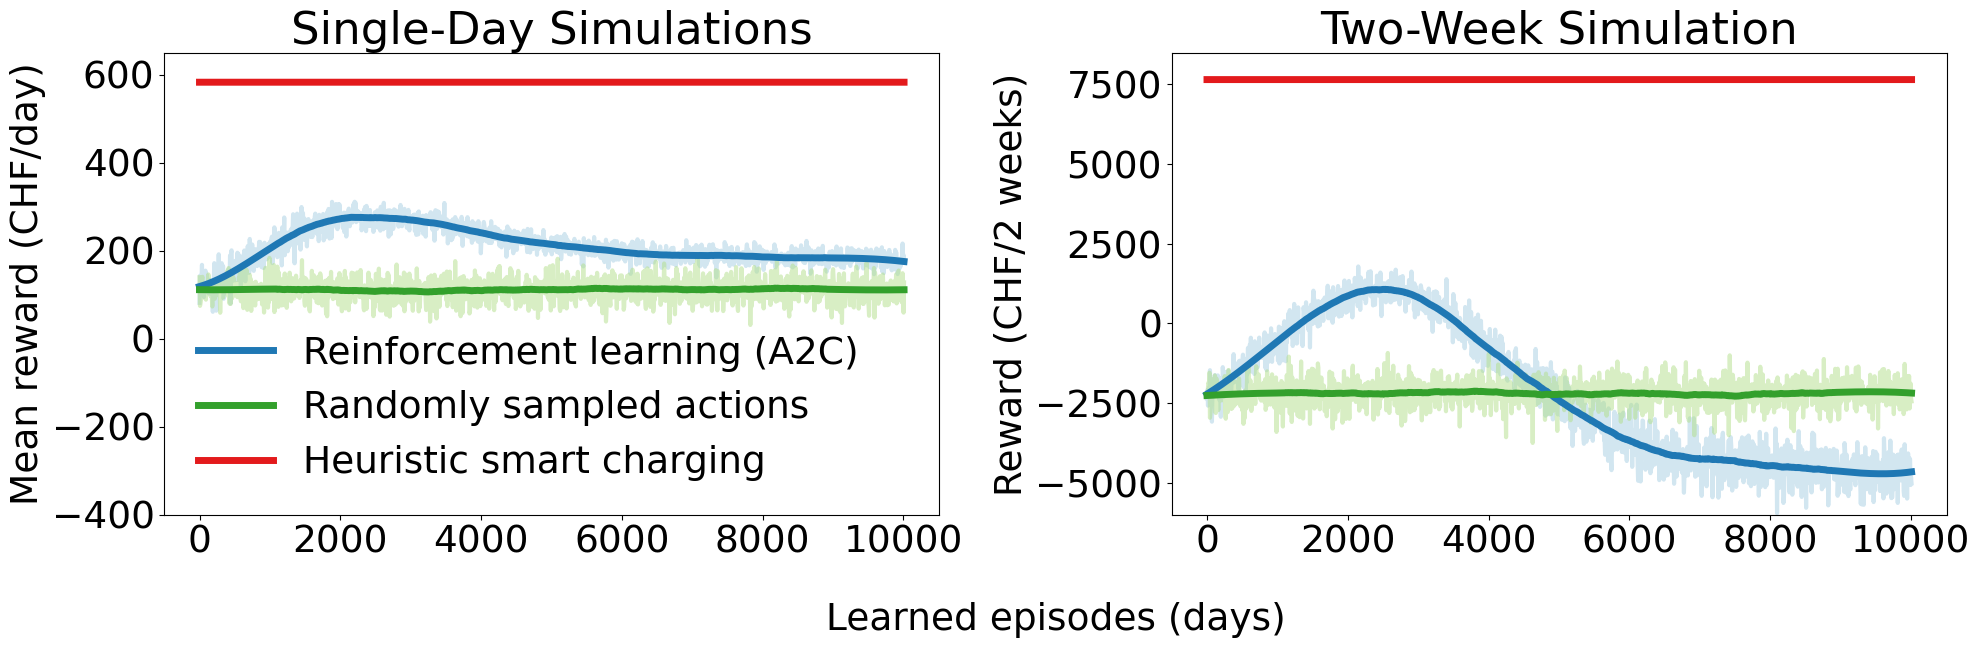

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Set font size
plt.rcParams.update({'font.size': 27, 'font.weight': 'medium'})
# Adjust figure dimensions
plt.figure(figsize=(23, 6))

# Plot 1
reward_smooth = savgol_filter(reward_list_long_term, window_length=310, polyorder=3)
reward_random_smooth = savgol_filter(reward_list_random_long_term, window_length=310, polyorder=3)

# Create the first subplot
plt.subplot(1, 2, 2)
plt.plot(count_list, reward_list_long_term, color="#a6cee3", alpha=0.5, linewidth=3.0)
plt.plot(count_list, reward_list_random_long_term, color="#b2df8a", alpha=0.5, linewidth=3.0)
plt.plot(count_list, reward_smooth, label='Reinforcement learning (A2C)', color="#1f78b4", linewidth=5.0)
plt.plot(count_list, reward_random_smooth, label='Randomly sampled actions', color="#33a02c", linewidth=5.0)
plt.plot(count_list, reward_list_smart_charging_long_term, label='Analytical smart charging', color="#e31a1c", linewidth=5.0)
plt.title("Two-Week Simulation", fontweight='medium')
plt.ylabel('Reward (CHF/2 weeks)')
xlabel = plt.xlabel('Learned episodes (days)', labelpad=30)
xlabel.set_x(-0.15)
plt.ylim(-6000, 8500)
# Get the current Axes object
ax = plt.gca()

# Set the plot background color to white
ax.set_facecolor('white')


# Plot 2
reward_smooth = savgol_filter(reward_list_daily, window_length=310, polyorder=3)
reward_random_smooth = savgol_filter(reward_list_random_daily, window_length=310, polyorder=3)

# Create the second subplot
plt.subplot(1, 2, 1)
plt.plot(count_list, np.array(reward_list_daily)/14, color="#a6cee3", alpha=0.5, linewidth=3.0)
plt.plot(count_list, np.array(reward_list_random_daily)/14, color="#b2df8a", alpha=0.5, linewidth=3.0)
plt.plot(count_list, np.array(reward_smooth)/14, label='Reinforcement learning (A2C)', color="#1f78b4", linewidth=5.0)
plt.plot(count_list, np.array(reward_random_smooth)/14, label='Randomly sampled actions', color="#33a02c", linewidth=5.0)
plt.plot(count_list, np.array(reward_list_smart_charging_daily)/14, label='Heuristic smart charging', color="#e31a1c", linewidth=5.0)
plt.title("Single-Day Simulations", fontweight='medium')
plt.ylabel('Mean reward (CHF/day)')
plt.ylim(-400, 650)
plt.legend(loc="lower left")

plt.legend(frameon=False)

# Get the current Axes object
ax = plt.gca()

# Set the plot background color to white
ax.set_facecolor('white')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)


# Show the plots
plt.savefig('plot.png', dpi=500, transparent=True)
plt.show()


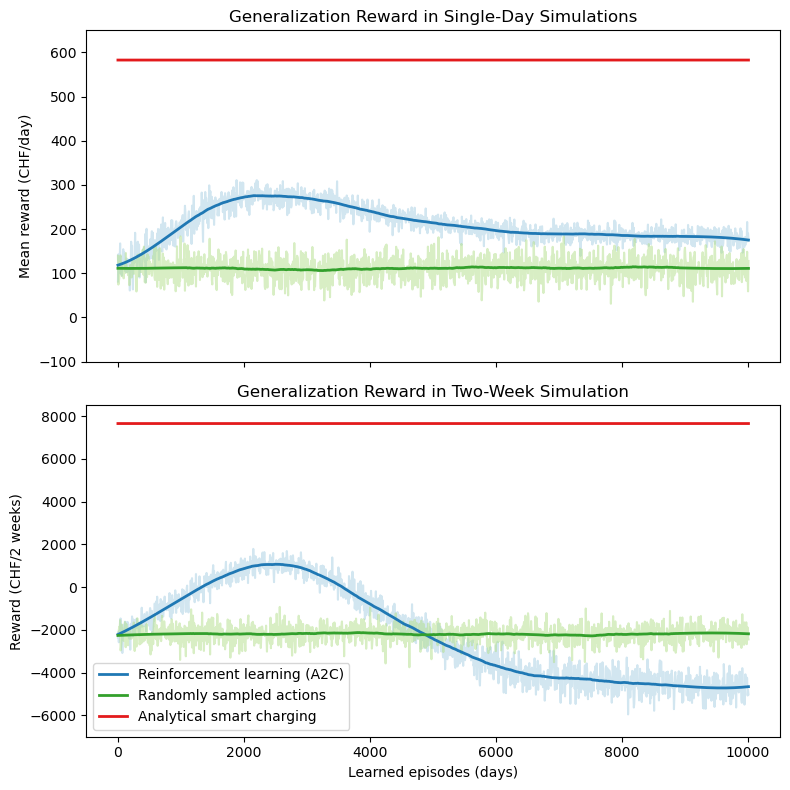

In [51]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

reward_smooth = savgol_filter(reward_list_daily, window_length=310, polyorder=3)
reward_random_smooth = savgol_filter(reward_list_random_daily, window_length=310, polyorder=3)
# Plot data for plot 2
ax1.plot(count_list, np.array(reward_list_daily)/14, color="#a6cee3", alpha=0.5)
ax1.plot(count_list, np.array(reward_list_random_daily)/14, color="#b2df8a", alpha=0.5)
ax1.plot(count_list, np.array(reward_smooth)/14, label='Reinforcement learning (A2C)', color="#1f78b4", linewidth=2.0)
ax1.plot(count_list, np.array(reward_random_smooth)/14, label='Randomly sampled actions', color="#33a02c", linewidth=2.0)
ax1.plot(count_list, np.array(reward_list_smart_charging_daily)/14, label='Analytical smart charging', color="#e31a1c", linewidth=2.0)
ax1.set_title("Generalization Reward in Single-Day Simulations")
ax1.set_ylabel('Mean reward (CHF/day)')
ax1.set_ylim(-100, 650)


reward_smooth = savgol_filter(reward_list_long_term, window_length=310, polyorder=3)
reward_random_smooth = savgol_filter(reward_list_random_long_term, window_length=310, polyorder=3)

# Plot data for plot 1
ax2.plot(count_list, reward_list_long_term, color="#a6cee3", alpha=0.5)
ax2.plot(count_list, reward_list_random_long_term, color="#b2df8a", alpha=0.5)
ax2.plot(count_list, reward_smooth, label='Reinforcement learning (A2C)', color="#1f78b4", linewidth=2.0)
ax2.plot(count_list, reward_random_smooth, label='Randomly sampled actions', color="#33a02c", linewidth=2.0)
ax2.plot(count_list, reward_list_smart_charging_long_term, label='Analytical smart charging', color="#e31a1c", linewidth=2.0)
ax2.set_title("Generalization Reward in Two-Week Simulation")
ax2.set_ylabel('Reward (CHF/2 weeks)')
ax2.set_ylim(-7000, 8500)
ax2.legend(loc="lower left")
ax2.set_xlabel('Learned episodes (days)')


plt.tight_layout()
plt.show()